In [7]:
# Import base libraries for EDA
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as img
import os
import glob
from PIL import Image
import re
import seaborn as sns

# Import TensorFlow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.optimizers import Adam


In [8]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [9]:
# Import the data from the main file(s)
file_path = "C:/Users/colts/OneDrive/Desktop/COMP 4449/Multi-class Weather Dataset"
folders = os.listdir(file_path)
ext = ['jpg','jpeg']

# Folders for modeling
print(folders)

# Collect images and their respective labels
def CollectImages(PATH, folder, image_ext):
    images = []
    for ext in image_ext:
        for file in glob.glob(PATH + "/" + folder + '/*.' + ext):
            # Using Pillow to reshape and convert the images
            images.append(file)

    # Displays number of images in each folder
    print(f"Number of Images in folder {folder}: {len(images)}")
    
    # Shuffles for randomness
    np.random.shuffle(images)
    
    # Returns the list of images along with an index of values that changes each run
    return images, np.array([folder for i in range(len(images))])

['Cloudy', 'Hail', 'Lightning', 'Rain', 'Shine', 'Snow', 'Sunrise']


In [10]:
# I want to re-read the files in as categorical, reducing the time needed to run a deep-layer CNN
image_h = 224
image_w = 224

fields = len(folders)
train_ds = tf.keras.utils.image_dataset_from_directory(
    file_path,
    validation_split=0.2,
    subset="training",
    label_mode="categorical",
    seed=12345,
    image_size=(image_w, image_h),
    batch_size=32)

val_ds = tf.keras.utils.image_dataset_from_directory(
    file_path,
    validation_split=0.2,
    subset="validation",
    label_mode="categorical",
    seed=12345,
    image_size=(image_w, image_h),
    batch_size=32)

Found 2245 files belonging to 7 classes.
Using 1796 files for training.
Found 2245 files belonging to 7 classes.
Using 449 files for validation.


In [11]:
# Implement a smaller version of ResNet152, ResNet50
weather_model_ResNet50 = keras.applications.resnet50.ResNet50(weights='imagenet', include_top=False, 
                                                              input_shape=(image_h, image_w, 3))

# Trainability
weather_model_ResNet50.trainable = False

# Build like a Sequential
run_model = keras.Sequential([
    weather_model_ResNet50,
    keras.layers.MaxPooling2D(),
    keras.layers.Flatten(),
    keras.layers.Dense(fields, activation="softmax")
])

# Summary
run_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 3, 3, 2048)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 18432)             0         
                                                                 
 dense_1 (Dense)             (None, 7)                 129031    
                                                                 
Total params: 23,716,743
Trainable params: 129,031
Non-trainable params: 23,587,712
_________________________________________________________________


In [12]:
# Compile
run_model.compile(optimizer="Adam", loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])
epochs = 15

# Fit and run
history_4 = run_model.fit(
        train_ds, 
        validation_data=val_ds, 
        epochs=epochs
    )

Epoch 1/15
57/57 [==============================] - 12s 160ms/step - loss: 1.2666 - accuracy: 0.8168 - val_loss: 1.0282 - val_accuracy: 0.8575
Epoch 2/15
57/57 [==============================] - 7s 125ms/step - loss: 0.2743 - accuracy: 0.9532 - val_loss: 0.6030 - val_accuracy: 0.9220
Epoch 3/15
57/57 [==============================] - 7s 127ms/step - loss: 0.0590 - accuracy: 0.9850 - val_loss: 0.5188 - val_accuracy: 0.9399
Epoch 4/15
57/57 [==============================] - 7s 127ms/step - loss: 0.0332 - accuracy: 0.9928 - val_loss: 0.8862 - val_accuracy: 0.9287
Epoch 5/15
57/57 [==============================] - 7s 126ms/step - loss: 0.0266 - accuracy: 0.9939 - val_loss: 0.6796 - val_accuracy: 0.9310
Epoch 6/15
57/57 [==============================] - 7s 126ms/step - loss: 0.0126 - accuracy: 0.9978 - val_loss: 0.8380 - val_accuracy: 0.9131
Epoch 7/15
57/57 [==============================] - 8s 128ms/step - loss: 0.0318 - accuracy: 0.9928 - val_loss: 0.9959 - val_accuracy: 0.9109
Epoch

In [13]:
# Save the model for future use
# keras.models.save_model(run_model, "ResNet50_WX.h5")

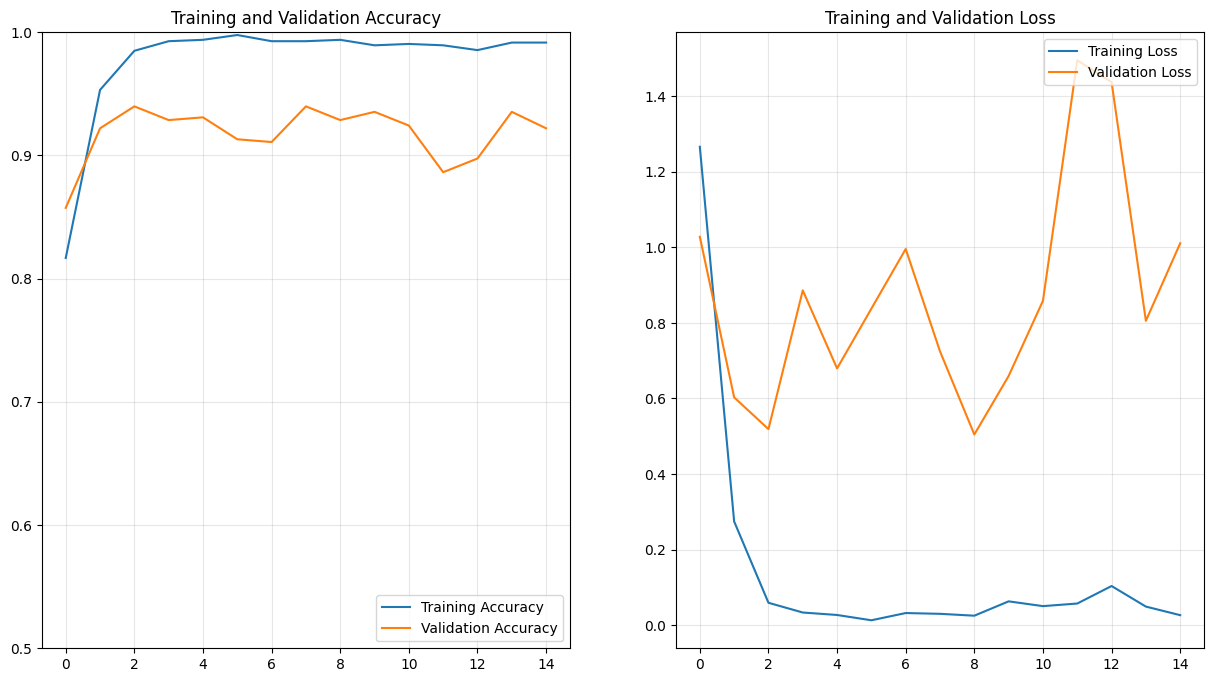

In [14]:
# Plots depicting second models accuracy/loss
training_acc = history_4.history['accuracy']
validation_acc = history_4.history['val_accuracy']

training_loss = history_4.history['loss']
validation_loss = history_4.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(15, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, training_acc, label='Training Accuracy')
plt.plot(epochs_range, validation_acc, label='Validation Accuracy')
plt.ylim([0.5,1])
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.grid(alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(epochs_range, training_loss, label='Training Loss')
plt.plot(epochs_range, validation_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.grid(alpha=0.3)
plt.show()

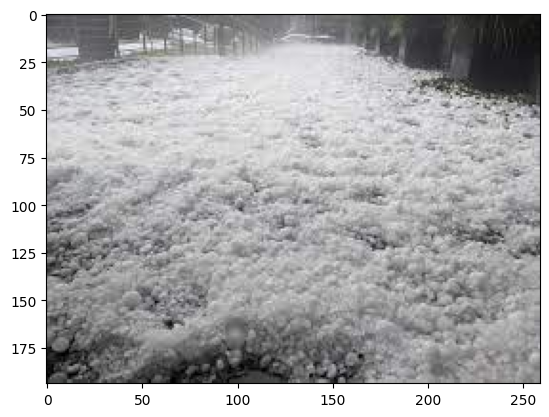

In [15]:
# Test the models with new images
image_path = "C:/Users/colts/OneDrive/Desktop/COMP 4449/testing_images/Hail_02.jpg"
image_test = Image.open(image_path)
plt.imshow(image_test)

In [16]:
# ResNet50 Model testing
img = tf.keras.utils.load_img(
    image_path, target_size=(224, 224)
)

img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

predictions = run_model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(folders[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 1s 765ms/step
This image most likely belongs to Hail with a 31.18 percent confidence.


#### Saving and Testing the ResNet50 Model

In [17]:
# image_path = "C:/Users/colts/OneDrive/Desktop/COMP 4449/testing_images/Lightning_01.jpg"
# test_load = keras.models.load_model("ResNet50_WX.h5")
# test_load.summary()